<a href="https://colab.research.google.com/github/Dzikrifaza/FreshGrocie/blob/ml_dev/FreshGrocie_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library

In [1]:
!pip install opendatasets
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.utils import Sequence

import opendatasets as od
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import splitfolders 
import pandas as pd
import os

import shutil
from PIL import Image

%matplotlib inline

import matplotlib.image as mpimg

#Download Dataset

In [3]:
od.download("https://www.kaggle.com/datasets/muhriddinmuxiddinov/fruits-and-vegetables-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dianaayum151dsy1844
Your Kaggle Key: ··········


100%|██████████| 870M/870M [00:49<00:00, 18.5MB/s]


# Split Data

In [4]:
splitfolders.ratio('/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset(12000)/Fruits', 
                   output="/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/Fruits/", 
                   seed=42, 
                   ratio=(0.8,0.1,0.1), # training, val, test
                   group_prefix=None)

Copying files: 5997 files [00:01, 3430.00 files/s]


In [5]:
splitfolders.ratio('/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset(12000)/Vegetables', 
                   output="/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/Vegetables", 
                   seed=42, 
                   ratio=(0.8,0.1,0.1), # training, val, test
                   group_prefix=None)

Copying files: 6003 files [00:01, 3250.03 files/s]


#Merge Train and Test Data for Fruits and Vegetables 

Funtion for moving the directory

In [6]:
def move_dir(src, dest, dir_list):
  for dir_ in dir_list:
    source = os.path.join(src, dir_)

    if os.path.isdir(source):
        shutil.move(source, dest)

In [7]:
def move_subdir(source, dest, subdir):
  if not os.path.isdir(dest):
      os.mkdir(dest)

  src_path = os.path.join(source, subdir)
  for item_list in os.listdir(src_path):
      src = os.path.join(src_path, item_list)
      dst = os.path.join(dest, item_list)
      shutil.move(src, dst)

  os.rmdir(src_path)

Train Data:

Taking the data from fruits and vegetables and combine them into 1 training data

In [8]:
source_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/Fruits'

dir_list = ['train']

dest_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset'
dest = os.path.join(dest_path, 'train')

move_dir(source_path, dest, dir_list)

In [9]:
source_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/Vegetables'

subdir = 'train'

dest_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/train'

move_subdir(source_path, dest_path, subdir)

Validation Data:

Taking the data from fruits and vegetables and combine them into 1 validation data

In [10]:
source_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/Fruits'

dir_list = ['val']

dest_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset'
dest = os.path.join(dest_path, 'val')

move_dir(source_path, dest, dir_list)

In [11]:
source_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/Vegetables'

subdir = 'val'

dest_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/val'

move_subdir(source_path, dest_path, subdir)

Test Data:

Taking the data from fruits and vegetables and combine them into 1 testing data

In [12]:
source_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/Fruits'
 
dir_list = ['test']
 
dest_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset'
dest = os.path.join(dest_path, 'test')

move_dir(source_path, dest, dir_list)

In [13]:
source_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/Vegetables'

subdir = 'test'

dest_path = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/test'

move_subdir(source_path, dest_path, subdir)

#Assign

In [14]:
train_FileNames = os.path.join('/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/train')
val_FileNames = os.path.join('/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/val')
test_FileNames = os.path.join('/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset/test')

#Showing Dataset

In [15]:
#train_fruits
train_freshApple = os.path.join(train_FileNames, 'FreshApple')
train_freshBanana = os.path.join(train_FileNames, 'FreshBanana')
train_freshMango = os.path.join(train_FileNames, 'FreshMango')
train_freshOrange = os.path.join(train_FileNames, 'FreshOrange')
train_freshStrawberry = os.path.join(train_FileNames, 'FreshStrawberry')
train_rottenApple = os.path.join(train_FileNames, 'RottenApple')
train_rottenBanana = os.path.join(train_FileNames, 'RottenBanana')
train_rottenMango = os.path.join(train_FileNames, 'RottenMango')
train_rottenOrange = os.path.join(train_FileNames, 'RottenOrange')
train_rottenStrawberry = os.path.join(train_FileNames, 'RottenStrawberry')

#train_vegetables
train_freshBellpepper = os.path.join(train_FileNames, 'FreshBellpepper')
train_freshCarrot = os.path.join(train_FileNames, 'FreshCarrot')
train_freshCucumber = os.path.join(train_FileNames, 'FreshCucumber')
train_freshPotato = os.path.join(train_FileNames, 'FreshPotato')
train_freshTomato = os.path.join(train_FileNames, 'FreshTomato')
train_rottenBellpepper = os.path.join(train_FileNames, 'RottenBellpepper')
train_rottenCarrot = os.path.join(train_FileNames, 'RottenCarrot')
train_rottenCucumber = os.path.join(train_FileNames, 'RottenCucumber')
train_rottenPotato = os.path.join(train_FileNames, 'RottenPotato')
train_rottenTomato = os.path.join(train_FileNames, 'RottenTomato')

#val_fruits
val_freshApple = os.path.join(val_FileNames, 'FreshApple')
val_freshBanana = os.path.join(val_FileNames, 'FreshBanana')
val_freshMango = os.path.join(val_FileNames, 'FreshMango')
val_freshOrange = os.path.join(val_FileNames, 'FreshOrange')
val_freshStrawberry = os.path.join(val_FileNames, 'FreshStrawberry')
val_rottenApple = os.path.join(val_FileNames, 'RottenApple')
val_rottenBanana = os.path.join(val_FileNames, 'RottenBanana')
val_rottenMango = os.path.join(val_FileNames, 'RottenMango')
val_rottenOrange = os.path.join(val_FileNames, 'RottenOrange')
val_rottenStrawberry = os.path.join(val_FileNames, 'RottenStrawberry')

#val_vegetables
val_freshBellpepper = os.path.join(val_FileNames, 'FreshBellpepper')
val_freshCarrot = os.path.join(val_FileNames, 'FreshCarrot')
val_freshCucumber = os.path.join(val_FileNames, 'FreshCucumber')
val_freshPotato = os.path.join(val_FileNames, 'FreshPotato')
val_freshTomato = os.path.join(val_FileNames, 'FreshTomato')
val_rottenBellpepper = os.path.join(val_FileNames, 'RottenBellpepper')
val_rottenCarrot = os.path.join(val_FileNames, 'RottenCarrot')
val_rottenCucumber = os.path.join(val_FileNames, 'RottenCucumber')
val_rottenPotato = os.path.join(val_FileNames, 'RottenPotato')
val_rottenTomato = os.path.join(val_FileNames, 'RottenTomato')

#test_fruits
test_freshApple = os.path.join(test_FileNames, 'FreshApple')
test_freshBanana = os.path.join(test_FileNames, 'FreshBanana')
test_freshMango = os.path.join(test_FileNames, 'FreshMango')
test_freshOrange = os.path.join(test_FileNames, 'FreshOrange')
test_freshStrawberry = os.path.join(test_FileNames, 'FreshStrawberry')
test_rottenApple = os.path.join(test_FileNames, 'RottenApple')
test_rottenBanana = os.path.join(test_FileNames, 'RottenBanana')
test_rottenMango = os.path.join(test_FileNames, 'RottenMango')
test_rottenOrange = os.path.join(test_FileNames, 'RottenOrange')
test_rottenStrawberry = os.path.join(test_FileNames, 'RottenStrawberry')

#test_vegetables
test_freshBellpepper = os.path.join(test_FileNames, 'FreshBellpepper')
test_freshCarrot = os.path.join(test_FileNames, 'FreshCarrot')
test_freshCucumber = os.path.join(test_FileNames, 'FreshCucumber')
test_freshPotato = os.path.join(test_FileNames, 'FreshPotato')
test_freshTomato = os.path.join(test_FileNames, 'FreshTomato')
test_rottenBellpepper = os.path.join(test_FileNames, 'RottenBellpepper')
test_rottenCarrot = os.path.join(test_FileNames, 'RottenCarrot')
test_rottenCucumber = os.path.join(test_FileNames, 'RottenCucumber')
test_rottenPotato = os.path.join(test_FileNames, 'RottenPotato')
test_rottenTomato = os.path.join(test_FileNames, 'RottenTomato')

In [16]:
#list train_fruits
train_freshApple_fnames = os.listdir(train_freshApple)
train_freshBanana_fnames = os.listdir(train_freshBanana)
train_freshMango_fnames = os.listdir(train_freshMango)
train_freshOrange_fnames = os.listdir(train_freshOrange)
train_freshStrawberry_fnames = os.listdir(train_freshStrawberry)
train_rottenApple_fnames = os.listdir(train_rottenApple)
train_rottenBanana_fnames = os.listdir(train_rottenBanana)
train_rottenMango_fnames = os.listdir(train_rottenMango)
train_rottenOrange_fnames = os.listdir(train_rottenOrange)
train_rottenStrawberry_fnames = os.listdir(train_rottenStrawberry)

#list train_vegetables
train_freshBellpepper_fnames = os.listdir(train_freshBellpepper)
train_freshCarrot_fnames = os.listdir(train_freshCarrot)
train_freshCucumber_fnames = os.listdir(train_freshCucumber)
train_freshPotato_fnames = os.listdir(train_freshPotato)
train_freshTomato_fnames = os.listdir(train_freshTomato)
train_rottenBellpepper_fnames = os.listdir(train_rottenBellpepper)
train_rottenCarrot_fnames = os.listdir(train_rottenCarrot)
train_rottenCucumber_fnames = os.listdir(train_rottenCucumber)
train_rottenPotato_fnames = os.listdir(train_rottenPotato)
train_rottenTomato_fnames = os.listdir(train_rottenTomato)

#list val fruits
val_freshApple_fnames = os.listdir(val_freshApple)
val_freshBanana_fnames = os.listdir(val_freshBanana)
val_freshMango_fnames = os.listdir(val_freshMango)
val_freshOrange_fnames =  os.listdir(val_freshOrange)
val_freshStrawberry_fnames = os.listdir(val_freshStrawberry)
val_rottenApple_fnames = os.listdir(val_rottenApple)
val_rottenBanana_fnames = os.listdir(val_rottenBanana)
val_rottenMango_fnames = os.listdir(val_rottenMango)
val_rottenOrange_fnames  = os.listdir(val_rottenOrange)
val_rottenStrawberry_fnames = os.listdir(val_rottenStrawberry)

#list val vegetables
val_freshBellpepper_fnames = os.listdir(val_freshBellpepper)
val_freshCarrot_fnames = os.listdir(val_freshCarrot)
val_freshCucumber_fnames = os.listdir(val_freshCucumber)
val_freshPotato_fnames = os.listdir(val_freshPotato)
val_freshTomato_fnames = os.listdir(val_freshTomato)
val_rottenBellpepper_fnames = os.listdir(val_rottenBellpepper)
val_rottenCarrot_fnames = os.listdir(val_rottenCarrot)
val_rottenCucumber_fnames = os.listdir(val_rottenCucumber)
val_rottenPotato_fnames = os.listdir(val_rottenPotato)
val_rottenTomato_fnames = os.listdir(val_rottenTomato)

#list test fruits
test_freshApple_fnames = os.listdir(test_freshApple)
test_freshBanana_fnames = os.listdir(test_freshBanana)
test_freshMango_fnames = os.listdir(test_freshMango)
test_freshOrange_fnames =  os.listdir(test_freshOrange)
test_freshStrawberry_fnames = os.listdir(test_freshStrawberry)
test_rottenApple_fnames = os.listdir(test_rottenApple)
test_rottenBanana_fnames = os.listdir(test_rottenBanana)
test_rottenMango_fnames = os.listdir(test_rottenMango)
test_rottenOrange_fnames  = os.listdir(test_rottenOrange)
test_rottenStrawberry_fnames = os.listdir(test_rottenStrawberry)

#list test vegetables
test_freshBellpepper_fnames = os.listdir(test_freshBellpepper)
test_freshCarrot_fnames = os.listdir(test_freshCarrot)
test_freshCucumber_fnames = os.listdir(test_freshCucumber)
test_freshPotato_fnames = os.listdir(test_freshPotato)
test_freshTomato_fnames = os.listdir(test_freshTomato)
test_rottenBellpepper_fnames = os.listdir(test_rottenBellpepper)
test_rottenCarrot_fnames = os.listdir(test_rottenCarrot)
test_rottenCucumber_fnames = os.listdir(test_rottenCucumber)
test_rottenPotato_fnames = os.listdir(test_rottenPotato)
test_rottenTomato_fnames = os.listdir(test_rottenTomato)


print(train_freshApple_fnames[:5])
print(train_freshBanana_fnames[:5])
print(train_freshMango_fnames[:5])
print(train_freshOrange_fnames[:5])
print(train_freshStrawberry_fnames[:5])
print(train_rottenApple_fnames[:5])
print(train_rottenBanana_fnames[:5])
print(train_rottenMango_fnames[:5])
print(train_rottenOrange_fnames [:5])
print(train_rottenStrawberry_fnames[:5])
print(train_freshBellpepper_fnames[:5])
print(train_freshCarrot_fnames[:5])
print(train_freshCucumber_fnames[:5])
print(train_freshPotato_fnames[:5])
print(train_freshTomato_fnames[:5])
print(train_rottenBellpepper_fnames[:5])
print(train_rottenCarrot_fnames[:5])
print(train_rottenCucumber_fnames[:5])
print(train_rottenPotato_fnames [:5])
print(train_rottenTomato_fnames[:5])

print()
print()
print(val_freshApple_fnames[:5])
print(val_freshBanana_fnames[:5])
print(val_freshMango_fnames[:5])
print(val_freshOrange_fnames[:5])
print(val_freshStrawberry_fnames[:5])
print(val_rottenApple_fnames[:5])
print(val_rottenBanana_fnames[:5])
print(val_rottenMango_fnames[:5])
print(val_rottenOrange_fnames [:5])
print(val_rottenStrawberry_fnames[:5])
print(val_freshBellpepper_fnames[:5])
print(val_freshCarrot_fnames[:5])
print(val_freshCucumber_fnames[:5])
print(val_freshPotato_fnames[:5])
print(val_freshTomato_fnames[:5])
print(val_rottenBellpepper_fnames[:5])
print(val_rottenCarrot_fnames[:5])
print(val_rottenCucumber_fnames[:5])
print(val_rottenPotato_fnames [:5])
print(val_rottenTomato_fnames[:5])

print()
print()
print(test_freshApple_fnames[:5])
print(test_freshBanana_fnames[:5])
print(test_freshMango_fnames[:5])
print(test_freshOrange_fnames[:5])
print(test_freshStrawberry_fnames[:5])
print(test_rottenApple_fnames[:5])
print(test_rottenBanana_fnames[:5])
print(test_rottenMango_fnames[:5])
print(test_rottenOrange_fnames [:5])
print(test_rottenStrawberry_fnames[:5])
print(test_freshBellpepper_fnames[:5])
print(test_freshCarrot_fnames[:5])
print(test_freshCucumber_fnames[:5])
print(test_freshPotato_fnames[:5])
print(test_freshTomato_fnames[:5])
print(test_rottenBellpepper_fnames[:5])
print(test_rottenCarrot_fnames[:5])
print(test_rottenCucumber_fnames[:5])
print(test_rottenPotato_fnames [:5])
print(test_rottenTomato_fnames[:5])

['freshApple (238).jpg', 'freshApple (642).png', 'freshApple (282).jpg', 'freshApple (670).png', 'freshApple (493).png']
['freshBanana (163).jpg', 'freshBanana (27).jpg', 'freshBanana (161).jpg', 'freshBanana (338).jpg', 'freshBanana (307).jpg']
['freshMango (159).png', 'freshMango (198).jpg', 'freshMango (170).jpg', 'freshMango (3).png', 'freshMango (80).png']
['freshOrange (275).jpg', 'freshOrange (235).jpg', 'freshOrange (218).jpg', 'freshOrange (49).png', 'freshOrange (300).png']
['freshStrawberry (474).jpg', 'freshStrawberry (576).jpg', 'freshStrawberry (430).jpg', 'freshStrawberry (483).jpg', 'freshStrawberry (180).jpg']
['rottenApple (433).jpg', 'rottenApple (549).jpg', 'rottenApple (7).jpg', 'rottenApple (144).jpg', 'rottenApple (545).jpg']
['rottenBanana (565).jpg', 'rottenBanana (109).jpg', 'rottenBanana (1).webp', 'rottenBanana (212).jpg', 'rottenBanana (82).jpg']
['rottenMango (569).jpg', 'rottenMango (218).jpg', 'rottenMango (307).jpg', 'rottenMango (80).jpg', 'rottenMango

Checking the total of each class

In [17]:
print('total training appel fresh images      :', len(os.listdir(      train_freshApple ) ))
print('total training banana fresh images     :', len(os.listdir(      train_freshBanana ) ))
print('total training mango fresh images      :', len(os.listdir(      train_freshMango ) ))
print('total training orange fresh images     :', len(os.listdir(      train_freshOrange ) ))
print('total training strawberry fresh images :', len(os.listdir(      train_freshStrawberry ) ))
print('total training apple rotten images     :', len(os.listdir(      train_rottenApple ) ))
print('total training banana rotten images    :', len(os.listdir(      train_rottenBanana ) ))
print('total training mango rotten images     :', len(os.listdir(      train_rottenMango ) ))
print('total training orange rotten images    :', len(os.listdir(      train_rottenOrange ) ))
print('total training strawberry rotten images:', len(os.listdir(      train_rottenStrawberry ) ))
print()
print('total training bellpepper fresh images :', len(os.listdir(      train_freshBellpepper) ))
print('total training carrot fresh images     :', len(os.listdir(      train_freshCarrot ) ))
print('total training cucumber fresh images   :', len(os.listdir(      train_freshCucumber ) ))
print('total training potato fresh images     :', len(os.listdir(      train_freshPotato ) ))
print('total training tomato fresh images     :', len(os.listdir(      train_freshTomato ) ))
print('total training bellpepper rotten images:', len(os.listdir(      train_rottenBellpepper ) ))
print('total training carrot rotten images    :', len(os.listdir(      train_rottenCarrot ) ))
print('total training cucumber rotten images  :', len(os.listdir(      train_rottenCucumber ) ))
print('total training potato rotten images    :', len(os.listdir(      train_rottenPotato ) ))
print('total training tomato rotten images    :', len(os.listdir(      train_rottenTomato ) ))
print()
print()
print('total val appel fresh images           :', len(os.listdir(      val_freshApple ) ))
print('total val banana fresh images          :', len(os.listdir(      val_freshBanana ) ))
print('total val mango fresh images           :', len(os.listdir(      val_freshMango ) ))
print('total val orange fresh images          :', len(os.listdir(      val_freshOrange ) ))
print('total val strawberry fresh images      :', len(os.listdir(      val_freshStrawberry ) ))
print('total val apple rotten images          :', len(os.listdir(      val_rottenApple ) ))
print('total val banana rotten images         :', len(os.listdir(      val_rottenBanana ) ))
print('total val mango rotten images          :', len(os.listdir(      val_rottenMango ) ))
print('total val orange rotten images         :', len(os.listdir(      val_rottenOrange ) ))
print('total val strawberry rotten images     :', len(os.listdir(      val_rottenStrawberry ) ))
print()
print('total val bellpepper fresh images      :', len(os.listdir(      val_freshBellpepper) ))
print('total val carrot fresh images          :', len(os.listdir(      val_freshCarrot ) ))
print('total val cucumber fresh images        :', len(os.listdir(      val_freshCucumber ) ))
print('total val potato fresh images          :', len(os.listdir(      val_freshPotato ) ))
print('total val tomato fresh images          :', len(os.listdir(      val_freshTomato ) ))
print('total val bellpepper rotten images     :', len(os.listdir(      val_rottenBellpepper ) ))
print('total val carrot rotten images         :', len(os.listdir(      val_rottenCarrot ) ))
print('total val cucumber rotten images       :', len(os.listdir(      val_rottenCucumber ) ))
print('total val potato rotten images         :', len(os.listdir(      val_rottenPotato ) ))
print('total val tomato rotten images         :', len(os.listdir(      val_rottenTomato ) ))
print()
print()
print('total test appel fresh images           :', len(os.listdir(      test_freshApple ) ))
print('total test banana fresh images          :', len(os.listdir(      test_freshBanana ) ))
print('total test mango fresh images           :', len(os.listdir(      test_freshMango ) ))
print('total test orange fresh images          :', len(os.listdir(      test_freshOrange ) ))
print('total test strawberry fresh images      :', len(os.listdir(      test_freshStrawberry ) ))
print('total test apple rotten images          :', len(os.listdir(      test_rottenApple ) ))
print('total test banana rotten images         :', len(os.listdir(      test_rottenBanana ) ))
print('total test mango rotten images          :', len(os.listdir(      test_rottenMango ) ))
print('total test orange rotten images         :', len(os.listdir(      test_rottenOrange ) ))
print('total test strawberry rotten images     :', len(os.listdir(      test_rottenStrawberry ) ))
print()
print('total test bellpepper fresh images      :', len(os.listdir(      test_freshBellpepper) ))
print('total test carrot fresh images          :', len(os.listdir(      test_freshCarrot ) ))
print('total test cucumber fresh images        :', len(os.listdir(      test_freshCucumber ) ))
print('total test potato fresh images          :', len(os.listdir(      test_freshPotato ) ))
print('total test tomato fresh images          :', len(os.listdir(      test_freshTomato ) ))
print('total test bellpepper rotten images     :', len(os.listdir(      test_rottenBellpepper ) ))
print('total test carrot rotten images         :', len(os.listdir(      test_rottenCarrot ) ))
print('total test cucumber rotten images       :', len(os.listdir(      test_rottenCucumber ) ))
print('total test potato rotten images         :', len(os.listdir(      test_rottenPotato ) ))
print('total test tomato rotten images         :', len(os.listdir(      test_rottenTomato ) ))

total training appel fresh images      : 489
total training banana fresh images     : 499
total training mango fresh images      : 484
total training orange fresh images     : 487
total training strawberry fresh images : 482
total training apple rotten images     : 470
total training banana rotten images    : 460
total training mango rotten images     : 474
total training orange rotten images    : 472
total training strawberry rotten images: 476

total training bellpepper fresh images : 488
total training carrot fresh images     : 496
total training cucumber fresh images   : 486
total training potato fresh images     : 492
total training tomato fresh images     : 483
total training bellpepper rotten images: 472
total training carrot rotten images    : 464
total training cucumber rotten images  : 474
total training potato rotten images    : 468
total training tomato rotten images    : 476


total val appel fresh images           : 61
total val banana fresh images          : 62
total val

Showing the pictures

In [19]:
BATCH_SIZE = 20
IMAGE_SIZE = 224

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_FileNames,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 9581 files belonging to 20 classes.


In [20]:
class_names = train_dataset.class_names
class_names

['FreshApple',
 'FreshBanana',
 'FreshBellpepper',
 'FreshCarrot',
 'FreshCucumber',
 'FreshMango',
 'FreshOrange',
 'FreshPotato',
 'FreshStrawberry',
 'FreshTomato',
 'RottenApple',
 'RottenBanana',
 'RottenBellpepper',
 'RottenCarrot',
 'RottenCucumber',
 'RottenMango',
 'RottenOrange',
 'RottenPotato',
 'RottenStrawberry',
 'RottenTomato']

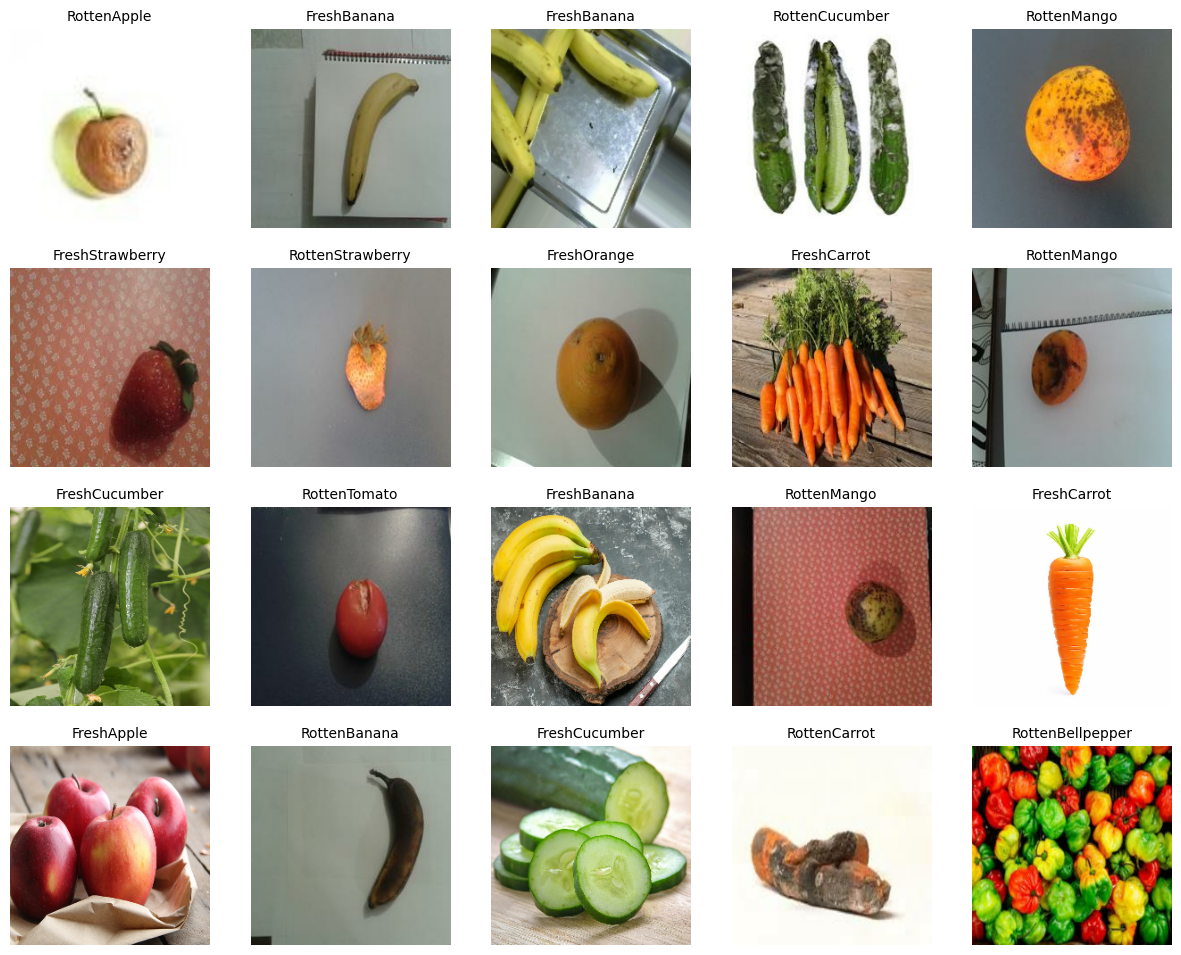

In [27]:
plt.figure(figsize = (15,15))
for image_batch, label_batch in train_dataset.take(1):
  for i in range(20):
     ax = plt.subplot(5,5,i+1)
     plt.imshow(image_batch[i].numpy().astype("uint8"))
     plt.title(class_names[label_batch[i]],fontsize = 10)
     plt.axis("off")

Convert the RGBA

In [ ]:
directory = "/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset"

for root, _, files in os.walk(directory):
    for file in files:
        if file.endswith(".png") or file.endswith(".webp"):
            image_path = os.path.join(root, file)

            with Image.open(image_path) as img:
                if img.mode == "P" and "transparency" in img.info:
                    img = img.convert("RGBA")

                save_path = os.path.splitext(image_path)[0] + ".png"
                if file.endswith(".webp"):
                    save_path = os.path.splitext(image_path)[0] + ".jpg"

                img.save(save_path)

#Model

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-05-28 08:41:42--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.128, 74.125.143.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  26.4MB/s    in 3.2s    

2023-05-28 08:41:45 (26.4 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
def create_pre_trained(local_weights_file):
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None,
                                  pooling ='max',
                                  classes = 20) 

  pre_trained_model.load_weights(local_weights_file)

  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained(local_weights_file)

In [ ]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  last_output = last_desired_layer.output

  return last_output

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

def create_final_model(pre_trained_model, last_output):
  x = layers.Flatten()(last_output)
  x = layers.Dense(216, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(20, activation='softmax')(x)        

  model = Model(inputs=pre_trained_model.input, outputs=x)

  return model

In [ ]:
model = create_final_model(pre_trained_model, last_output)

#Normalization

In [ ]:
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   brightness_range=(0.2, 0.8),
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_FileNames,  
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_FileNames,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 9582 images belonging to 20 classes.
Found 1192 images belonging to 20 classes.


#Adjust Learning Training

In [ ]:
def adjust_learning_rate():    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))

    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, 
                  metrics=["accuracy"]) 
    
    history = model.fit(train_generator, epochs=100, callbacks=[lr_schedule])
    
    return history

In [ ]:
lr_history = adjust_learning_rate()

Epoch 1/100
480/480 [==============================] - 125s 236ms/step - loss: 3.1251 - accuracy: 0.0494 - lr: 1.0000e-06
Epoch 2/100
480/480 [==============================] - 114s 237ms/step - loss: 3.0810 - accuracy: 0.0533 - lr: 1.1220e-06
Epoch 3/100
480/480 [==============================] - 113s 236ms/step - loss: 3.0538 - accuracy: 0.0535 - lr: 1.2589e-06
Epoch 4/100
480/480 [==============================] - 119s 248ms/step - loss: 3.0247 - accuracy: 0.0620 - lr: 1.4125e-06
Epoch 5/100
480/480 [==============================] - 114s 237ms/step - loss: 2.9855 - accuracy: 0.0742 - lr: 1.5849e-06
Epoch 6/100
480/480 [==============================] - 113s 236ms/step - loss: 2.9615 - accuracy: 0.0810 - lr: 1.7783e-06
Epoch 7/100
480/480 [==============================] - 113s 235ms/step - loss: 2.9281 - accuracy: 0.0964 - lr: 1.9953e-06
Epoch 8/100
480/480 [==============================] - 114s 237ms/step - loss: 2.8945 - accuracy: 0.1121 - lr: 2.2387e-06
Epoch 9/100
480/480 [===

(1e-06, 10.0, 0.0, 10.0)

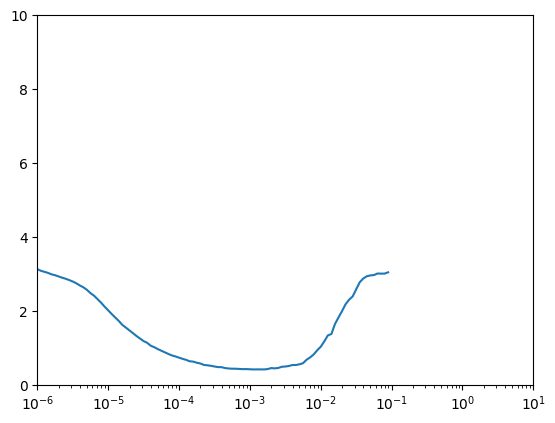

In [ ]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 10, 0, 10])

#Compile and Train the model

In [ ]:
model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.SGD(learning_rate=3.5481e-04, momentum=0.9),
                metrics=['accuracy'])

In [ ]:
EPOCHS = 20
  
history = model.fit(
      train_generator,
      batch_size = 20,
      steps_per_epoch=480,
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=59.6,
      verbose=2)

Epoch 1/20
480/480 - 126s - loss: 1.8168 - accuracy: 0.4635 - val_loss: 0.9005 - val_accuracy: 0.7190 - 126s/epoch - 263ms/step
Epoch 2/20
480/480 - 116s - loss: 1.0248 - accuracy: 0.6893 - val_loss: 0.6277 - val_accuracy: 0.8146 - 116s/epoch - 243ms/step
Epoch 3/20
480/480 - 117s - loss: 0.8127 - accuracy: 0.7484 - val_loss: 0.5083 - val_accuracy: 0.8507 - 117s/epoch - 244ms/step
Epoch 4/20
480/480 - 121s - loss: 0.7149 - accuracy: 0.7792 - val_loss: 0.4898 - val_accuracy: 0.8498 - 121s/epoch - 252ms/step
Epoch 5/20
480/480 - 118s - loss: 0.6320 - accuracy: 0.8067 - val_loss: 0.4385 - val_accuracy: 0.8633 - 118s/epoch - 246ms/step
Epoch 6/20
480/480 - 117s - loss: 0.5903 - accuracy: 0.8144 - val_loss: 0.4195 - val_accuracy: 0.8674 - 117s/epoch - 243ms/step
Epoch 7/20
480/480 - 119s - loss: 0.5581 - accuracy: 0.8246 - val_loss: 0.3776 - val_accuracy: 0.8851 - 119s/epoch - 248ms/step
Epoch 8/20
480/480 - 119s - loss: 0.5363 - accuracy: 0.8338 - val_loss: 0.3687 - val_accuracy: 0.8876 - 

# Check train and val performance

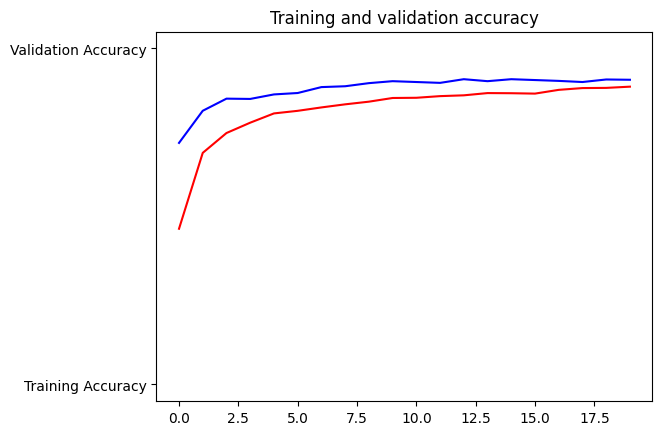

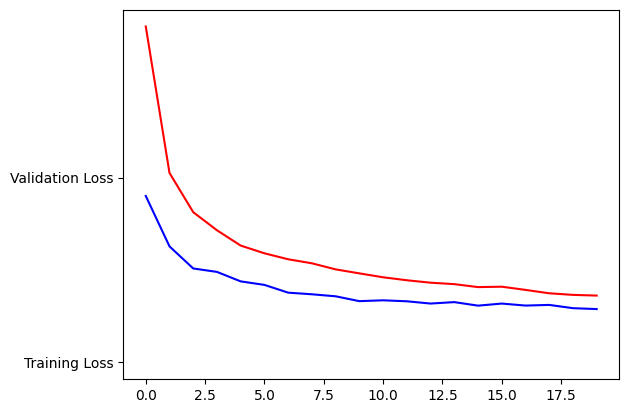

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data 
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

#Testing data

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_FileNames,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical',
        shuffle=False)

loss, accuracy = model.evaluate(test_generator)

print("Test accuracy:", accuracy)

Found 1216 images belonging to 20 classes.
61/61 [==============================] - 10s 167ms/step - loss: 0.2942 - accuracy: 0.9112
Test accuracy: 0.9111841917037964


In [ ]:
train_generator.class_indices

{'FreshApple': 0,
 'FreshBanana': 1,
 'FreshBellpepper': 2,
 'FreshCarrot': 3,
 'FreshCucumber': 4,
 'FreshMango': 5,
 'FreshOrange': 6,
 'FreshPotato': 7,
 'FreshStrawberry': 8,
 'FreshTomato': 9,
 'RottenApple': 10,
 'RottenBanana': 11,
 'RottenBellpepper': 12,
 'RottenCarrot': 13,
 'RottenCucumber': 14,
 'RottenMango': 15,
 'RottenOrange': 16,
 'RottenPotato': 17,
 'RottenStrawberry': 18,
 'RottenTomato': 19}

Saving kentang segar.jpg to kentang segar.jpg
1/1 [==============================] - 2s 2s/step
kentang segar.jpg
FreshPotato


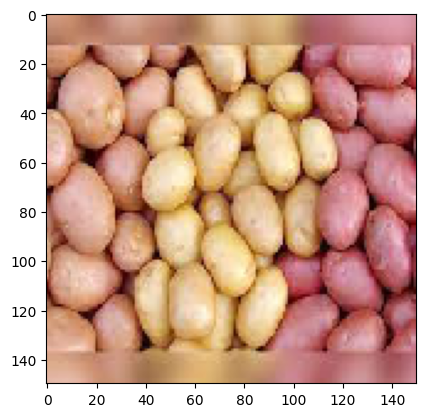

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files


uploaded = files.upload()

for fn in uploaded.keys():
  # Predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0  # Normalisasi gambar

  classess = model.predict(x)
  classes  = np.argmax(classess[0])

  print(fn)
  if classes==0:
    print('FreshApple')
  elif classes==1:
    print('FreshBanana')
  elif classes==2:
    print('FreshBellpepper')
  elif classes==3:
    print('FreshCarrot')
  elif classes==4:
    print('FreshCucumber')
  elif classes==5:
    print('FreshMango')
  elif classes==6:
    print('FreshOrange')
  elif classes==7:
    print('FreshPotato')
  elif classes==8:
    print('FreshStrawberry')
  elif classes==9:
    print('FreshTomato')
  elif classes==10:
    print('RottenApple')
  elif classes==11:
    print('RottenBanana')
  elif classes==12:
    print('RottenBellpepper')
  elif classes==13:
    print('RottenCarrot')
  elif classes==14:
    print('RottenCucumber')
  elif classes==15:
    print('RottenMango')
  elif classes==16:
    print('RottenOrange')
  elif classes==17:
    print('RottenPotato')
  elif classes==18:
    print('RottenStrawberry')
  else:
    print('RottenTomato')

#Make F1 table and Confusion Matrix

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def supervisedEvaluation(a, b):
    print('Confusion Matrix:')
    print(confusion_matrix(a, b))

    print('\nAccuracy Score:')
    accuracy = accuracy_score(a, b)
    print(accuracy)

    print('\nClassification Report:')
    print(classification_report(a, b))

    confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix(a, b))
    confusion_matrix_display.plot()
    plt.show()


61/61 [==============================] - 9s 147ms/step
Confusion Matrix:
[[58  0  0  0  0  2  1  0  0  4  0  0  0  0  0  0  0  0  0  0]
 [ 0 63  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0 58  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0 58  0  1  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  1  0 56  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0 55  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  2 61  0  0  3  0  0  0  0  0  0  1  0  0  1]
 [ 0  0  0  0  0  0  0 57  0  0  0  0  0  0  0  3  0  2  0  0]
 [ 0  0  1  0  0  0  0  0 61  0  0  0  0  0  0  0  0  0  1  0]
 [ 2  0  0  0  0  0  0  0  0 53  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  1  0  0 57  0  0  0  1  0  2  2  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0 56  0  1  0  0  0  0  0  0]
 [ 0  0  2  0  3  0  0  0  0  1  0  0 50  2  2  1  0  4  1  3]
 [ 0  0  0  3  0  0  0  1  0  0  0  0  1 49  1  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  0  3 5

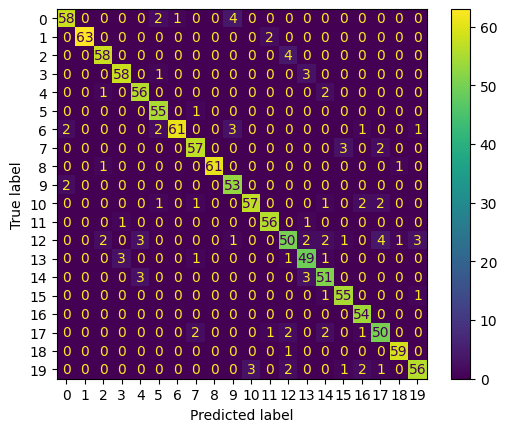

In [ ]:
predicted_labels = model.predict(test_generator)
true_labels = test_generator.classes
predicted_labels_multiclass = np.argmax(predicted_labels, axis=1)

supervisedEvaluation(predicted_labels_multiclass, true_labels)

In [ ]:
y_pred = model.predict(test_generator)
predicted_labels = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

tp = np.sum(np.logical_and(y_true == 1, predicted_labels == 1))
fp = np.sum(np.logical_and(y_true == 0, predicted_labels == 1))
tn = np.sum(np.logical_and(y_true == 0, predicted_labels == 0))
fn = np.sum(np.logical_and(y_true == 1, predicted_labels == 0))

data = {
    'Actual Positive': [tp, fn],
    'Actual Negative': [fp, tn]
}

index = ['Predicted Positive', 'Predicted Negative']
f1_table = pd.DataFrame(data, index=index)

print(f1_table)

61/61 [==============================] - 11s 170ms/step
                    Actual Positive  Actual Negative
Predicted Positive               62                0
Predicted Negative                0               58


#Save model

In [ ]:
#Save to H5 format
model.save("model_freshgrocie.h5")

In [ ]:
#Save to TFLite format
saved_model = tf.keras.models.load_model("model_freshgrocie.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(saved_model)
 
model_convert = converter.convert()
file_convert = open ("model_freshgrocie.tflite", "wb")
file_convert.write(model_convert)

68396428

In [ ]:
#Save to tfjs format
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

In [ ]:
import tensorflowjs as tfjs

saved_model = tf.keras.models.load_model("model_freshgrocie.h5")

tfjs.converters.save_keras_model(saved_model, '/content')

#Making the txt data

In [ ]:
dataset_dir = '/content/fruits-and-vegetables-dataset/Fruits_Vegetables_Dataset'

subdirectories = sorted(os.listdir(dataset_dir))

class_names = []
for subdir in subdirectories:
    subdir_path = os.path.join(dataset_dir, subdir)
    if os.path.isdir(subdir_path) and len(os.listdir(subdir_path)) > 0:
        class_directories = sorted(os.listdir(subdir_path))
        class_names.extend(class_directories)

class_names = sorted(list(set(class_names)))

label_mapping = {
    'FreshApple': 'Fresh Apple',
    'FreshBanana': 'Fresh Banana',
    'FreshBellpepper' : 'Fresh Bellpepper',
    'FreshCarrot' : 'Fresh Carrot',
    'FreshCucumber' : 'Fresh Cucumber',
    'FreshMango' : 'Fresh Mango',
    'FreshOrange' : 'Fresh Orange',
    'FreshPotato' : 'Fresh Potato',
    'FreshStrawberry' : 'Fresh Strawberry',
    'FreshTomato' : 'Fresh Tomato',
    'RottenApple': 'Rotten Apple',
    'RottenBanana': 'Rotten Banana',
    'RottenBellpepper' : 'Rotten Bellpepper',
    'RottenCarrot' : 'Rotten Carrot',
    'RottenCucumber' : 'Rotten Cucumber',
    'RottenMango' : 'Rotten Mango',
    'RottenOrange' : 'Rotten Orange',
    'RottenPotato' : 'Rotten Potato',
    'RottenStrawberry' : 'Rotten Strawberry',
    'RottenTomato' : 'Rotten Tomato'
}

with open('labels_class.txt', 'w') as f:
    for class_name in class_names:
      if class_name in label_mapping:
          new_class_name = label_mapping[class_name]
      else:
          new_class_name = class_name
          
      f.write(new_class_name + '\n')